# Previsão de Crimes em Toronto usando LSTM (PyTorch)

Este notebook carrega dados de crimes em Toronto, processa a série temporal de contagem diária e treina um modelo LSTM em PyTorch para prever o número de incidentes futuros.

## Instalação

Para instalar PyTorch, execute:
```bash
%pip install torch torchvision torchaudio
```

In [63]:
%pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


## 1. Importações

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## 2. Carregamento e inspeção dos dados

In [65]:
# Ajuste o caminho conforme seu ambiente
df = pd.read_csv(
    'C:/Users/peder/Downloads/major-crime-indicators.csv',
    parse_dates=['REPORT_DATE'],
    low_memory=False
)
df.head()

,_id,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,UCR_CODE,UCR_EXT,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,1,GO-20141263217,2014-01-01,2013-12-31,2014,January,1,1,Wednesday,16,...,2135,210,Theft Of Motor Vehicle,Auto Theft,043,Victoria Village (43),043,Victoria Village (43),-79.306754,43.734654
1,2,GO-20141260715,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,3,...,1430,100,Assault,Assault,092,Corso Italia-Davenport (92),092,Corso Italia-Davenport (92),-79.455770,43.677775
2,3,GO-20141260730,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,3,...,1430,100,Assault,Assault,105,Lawrence Park North (105),105,Lawrence Park North (105),-79.406223,43.727681
3,4,GO-20141260597,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,2,...,1430,100,Assault,Assault,080,Palmerston-Little Italy (80),080,Palmerston-Little Italy (80),-79.415594,43.654946
4,5,GO-20141259762,2014-01-01,2013-12-31,2014,January,1,1,Wednesday,2,...,1430,100,Assault,Assault,164,Wellington Place (164),077,Waterfront Communities-The Island (77),-79.390786,43.649125


## 3. Agrupamento por data (contagem diária de crimes)

C:\Users\peder\AppData\Local\Temp\ipykernel_11388\314085611.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M', on='REPORT_DATE')


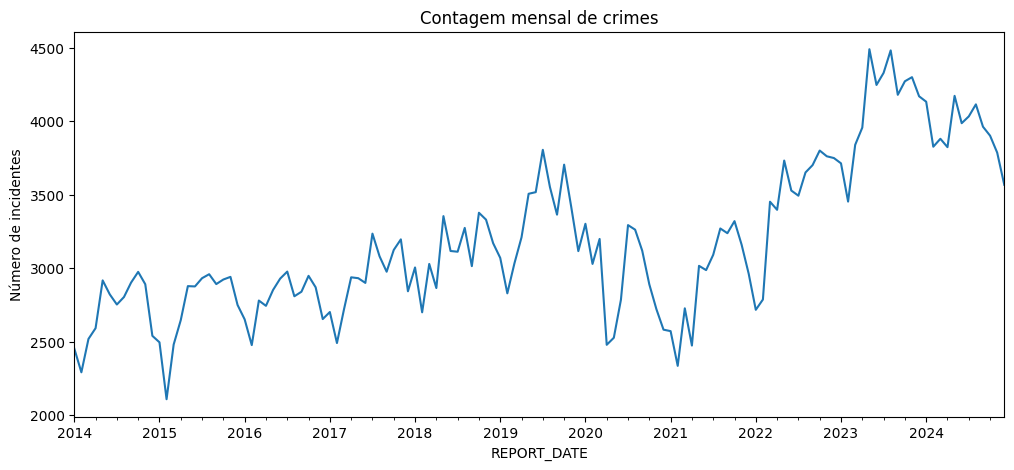

Formato de X: (125, 7, 1)
Formato de y: (125,)


In [66]:
# Supondo que 'df' já existe e contém a coluna 'REPORT_DATE'
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])

# 1) Agrupamento mensal das contagens
monthly_counts = (
    df
    .resample('M', on='REPORT_DATE')
    .size()
    .rename('count')
    .to_frame()
    .sort_index()
)

# 2) Plot da série bruta
plt.figure(figsize=(12, 5))
monthly_counts['count'].plot()
plt.title('Contagem mensal de crimes')
plt.ylabel('Número de incidentes')
plt.show()

# 3) Normalização com MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(monthly_counts[['count']].values)
# 'scaled' agora é um array de shape (n_meses, 1) com valores entre 0 e 1

# 4) Função para criar sequências (janelas de tempo)
def create_sequences(data_array, look_back=12):
    """
    Transforma um array 2D (n_amostras, 1) em pares (X, y),
    onde cada X[i] contém 'look_back' valores consecutivos e
    y[i] é o valor seguinte àquela janela.
    Retorna:
      - X: numpy array de shape (n_amostras - look_back, look_back, 1)
      - y: numpy array de shape (n_amostras - look_back,)
    """
    X, y = [], []
    for i in range(len(data_array) - look_back):
        seq_x = data_array[i : i + look_back]
        seq_y = data_array[i + look_back]
        X.append(seq_x)
        y.append(seq_y)
    X = np.array(X)       # shape = (n_amostras - look_back, look_back, 1)
    y = np.array(y).reshape(-1,)  # shape = (n_amostras - look_back,)
    return X, y

# 5) Definir quantos passos de look_back (por exemplo, 12 meses)
look_back = 7

# 6) Criar as sequências X e y
X, y = create_sequences(scaled, look_back)

# 7) Verificar formatos resultantes
print(f"Formato de X: {X.shape}")  # (n_amostras - look_back, look_back, 1)
print(f"Formato de y: {y.shape}")  # (n_amostras - look_back,)

## 4. Normalização dos dados

In [67]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_counts = scaler.fit_transform(monthly_counts[['count']].values)

## 5. Criação de sequências

In [68]:
def create_sequences(data, look_back=7):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 1
X, y = create_sequences(scaled_counts, look_back)

## 6. Preparação dos datasets e dataloaders

In [69]:
class CrimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Divisão em treino, validação, teste
total = len(X)
train_size = int(total * 0.7)
val_size = int(total * 0.15)
test_size = total - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]

train_loader = DataLoader(CrimeDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(CrimeDataset(X_val, y_val), batch_size=32)
test_loader  = DataLoader(CrimeDataset(X_test, y_test), batch_size=32)

## 7. Definição do modelo LSTM

In [70]:
class CrimeLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(CrimeLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CrimeLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

CrimeLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

## 8. Treinamento do modelo

In [71]:
num_epochs = 1000
for epoch in range(1, num_epochs + 1):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    print(f'Epoch {epoch}/{num_epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {np.mean(val_losses):.4f}')

Epoch 1/1000 | Train Loss: 0.2666 | Val Loss: 0.5130
Epoch 2/1000 | Train Loss: 0.2486 | Val Loss: 0.4868
Epoch 3/1000 | Train Loss: 0.2299 | Val Loss: 0.4612
Epoch 4/1000 | Train Loss: 0.2168 | Val Loss: 0.4362
Epoch 5/1000 | Train Loss: 0.1985 | Val Loss: 0.4112
Epoch 6/1000 | Train Loss: 0.1818 | Val Loss: 0.3864
Epoch 7/1000 | Train Loss: 0.1676 | Val Loss: 0.3619
Epoch 8/1000 | Train Loss: 0.1502 | Val Loss: 0.3403
Epoch 9/1000 | Train Loss: 0.1381 | Val Loss: 0.3194
Epoch 10/1000 | Train Loss: 0.1264 | Val Loss: 0.2988
Epoch 11/1000 | Train Loss: 0.1127 | Val Loss: 0.2781
Epoch 12/1000 | Train Loss: 0.1014 | Val Loss: 0.2580
Epoch 13/1000 | Train Loss: 0.0906 | Val Loss: 0.2374
Epoch 14/1000 | Train Loss: 0.0795 | Val Loss: 0.2163
Epoch 15/1000 | Train Loss: 0.0681 | Val Loss: 0.1949
Epoch 16/1000 | Train Loss: 0.0590 | Val Loss: 0.1735
Epoch 17/1000 | Train Loss: 0.0484 | Val Loss: 0.1523
Epoch 18/1000 | Train Loss: 0.0395 | Val Loss: 0.1317
Epoch 19/1000 | Train Loss: 0.0315 | 

## 9. Avaliação no conjunto de teste e visualização

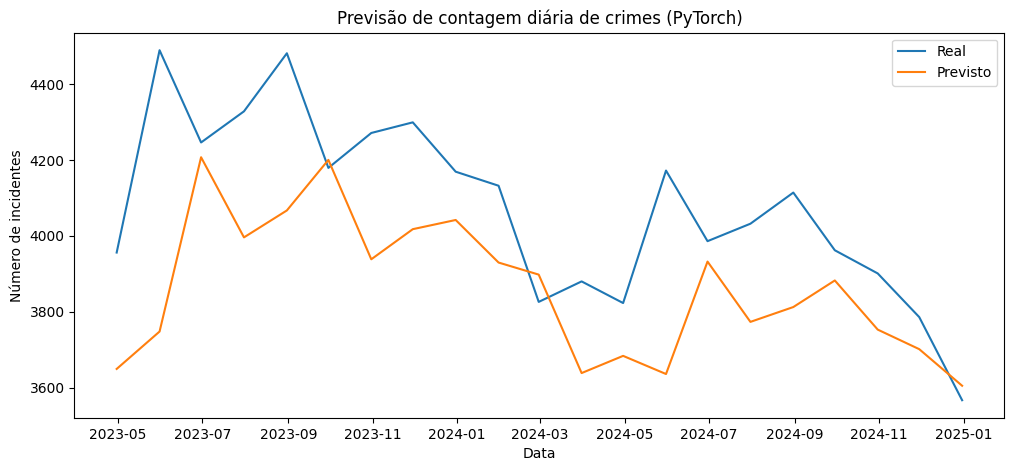

In [72]:
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        preds.extend(output.cpu().numpy())
        actuals.extend(y_batch.numpy())

# Inverter normalização
preds_inv = scaler.inverse_transform(np.array(preds))
actuals_inv = scaler.inverse_transform(np.array(actuals))

dates = monthly_counts.index[train_size + val_size + look_back:]
plt.figure(figsize=(12,5))
plt.plot(dates, actuals_inv, label='Real')
plt.plot(dates, preds_inv, label='Previsto')
plt.title('Previsão de contagem diária de crimes (PyTorch)')
plt.xlabel('Data')
plt.ylabel('Número de incidentes')
plt.legend()
plt.show()